In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mads_datasets import DatasetFactoryProvider, DatasetType
from scipy import stats

penguinsdataset = DatasetFactoryProvider.create_factory(DatasetType.PENGUINS)
penguinsdataset.download_data()

df = pd.read_parquet(penguinsdataset.filepath)
select = [
    "Species",
    "Island",
    "Culmen Length (mm)",
    "Culmen Depth (mm)",
    "Flipper Length (mm)",
    "Delta 15 N (o/oo)",
    "Delta 13 C (o/oo)",
    "Sex",
    "Body Mass (g)",
]
subset = df[select].dropna()
subset["Species"] = subset["Species"].apply(lambda x: x.split()[0])

2025-09-26 11:02:03.183 | INFO     | mads_datasets.base:download_data:94 - Start download...
  0%|          | 0.00/24.4k [00:00<?, ?iB/s]2025-09-26 11:02:06.530 | INFO     | mads_datasets.datatools:get_file:105 - Downloading C:\Users\avtnl\.cache\mads_datasets\penguins\penguins.parq
100%|██████████| 24.4k/24.4k [00:00<00:00, 12.2MiB/s]
2025-09-26 11:02:06.538 | INFO     | mads_datasets.base:download_data:112 - Digest of C:\Users\avtnl\.cache\mads_datasets\penguins\penguins.parq matches expected digest


So, we have this dataset. And we have some understanding of different types of distributions. Just from looking at the feature names it should be obvious that we can split the features into continuous and discrete features. 

But how do we find out which distribution fits our data best? Are these all normal distributions? Some of them, probably, but maybe not. How do we find out?

## Testing for normality

## qq-plot

The easiest way to test for normality is to use a qq-plot. This is a very basic and visual test. It is not very precise, but it is a good first step.

What is a qq-plot? It stands for quantile-quantile plot. It is a plot of the quantiles of the data against the quantiles of a theoretical distribution. If the data is normally distributed, the points will fall on a straight line. If the data is not normally distributed, the points will not fall on a straight line.

First, as a reminder, let's plot the PDFs for a normal and a skew-normal distribution.

Text(0.5, 1.0, 'Skewed distribution')

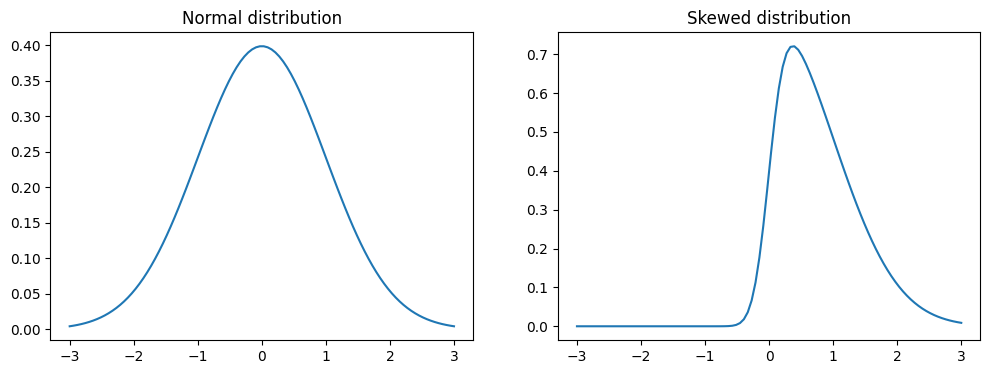

In [3]:
# prepare axes
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# get the pdfs for the two distributions
x = np.linspace(-3, 3, 100)
y1 = stats.norm.pdf(x, loc=0, scale=1)
y2 = stats.skewnorm.pdf(x, a=5, loc=0, scale=1)  # a is the skewness parameter

# plot the two distributions
ax[0].plot(x, y1)
ax[1].plot(x, y2)
ax[0].set_title("Normal distribution")
ax[1].set_title("Skewed distribution")

Now, let's sample some data from a distribution and see how the qq plot works.

Text(0.5, 1.0, 'Skew-normal Q-Q plot')

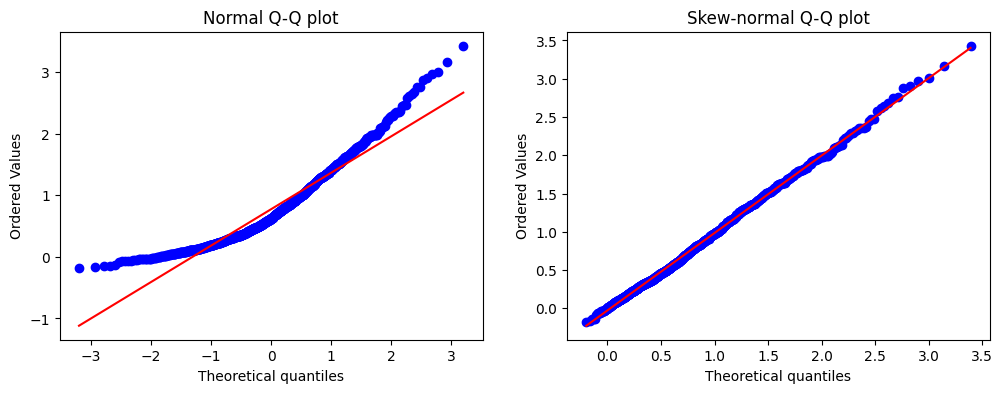

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
n = 1000
rng = np.random.default_rng(42)


# lets sample n times from a skewed normal distribution with alpha skewness
alpha = 10
data = stats.skewnorm.rvs(a=alpha, size=n, random_state=rng)

# first, we plot the data with a theoretical normal distribution
stats.probplot(data, plot=ax[0], dist=stats.norm)
ax[0].set_title("Normal Q-Q plot")

# then, we plot the data with a theoretical skewed normal distribution
stats.probplot(data, plot=ax[1], dist=stats.skewnorm, sparams=(alpha,))
ax[1].set_title("Skew-normal Q-Q plot")

# this also works the other way around! (eg generate normal data,
# and then the theoretical normal distribution will align,
# but the theoretical skewed normal distribution will not align)

As you can see, for the theoretical normal distribution, the points fall on a straight line. However, for a theoretical skew-normal distribution, the points do not fall on a straight line. You can see that the theory and the data do not match, which implicates that the data is not normally distributed.

In [5]:
subset.head()

,Species,Island,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Delta 15 N (o/oo),Delta 13 C (o/oo),Sex,Body Mass (g)
1,Adelie,Torgersen,39.5,17.4,186.0,8.94956,-24.69454,FEMALE,3800.0
2,Adelie,Torgersen,40.3,18.0,195.0,8.36821,-25.33302,FEMALE,3250.0
4,Adelie,Torgersen,36.7,19.3,193.0,8.76651,-25.32426,FEMALE,3450.0
5,Adelie,Torgersen,39.3,20.6,190.0,8.66496,-25.29805,MALE,3650.0
6,Adelie,Torgersen,38.9,17.8,181.0,9.18718,-25.21799,FEMALE,3625.0


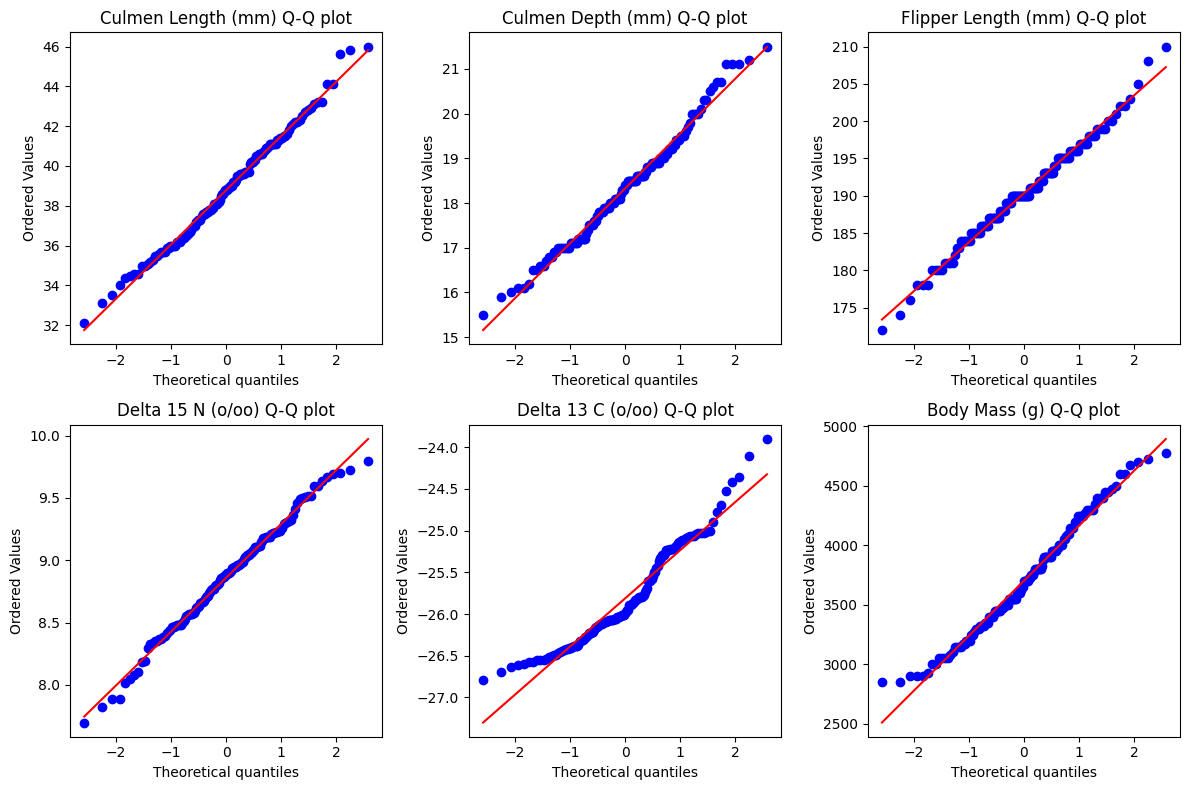

In [6]:
# let's test this for all continuous features from the penguins dataset

# select float columns, just from Adelie species
# question: what would happen if we used all species?
adelie = subset[subset["Species"] == "Adelie"]
floats = adelie.select_dtypes(include="float64")
features = floats.columns

# prepare axes
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.ravel()

for i, col in enumerate(features):
    feats = floats[col]
    stats.probplot(feats, plot=axs[i], dist=stats.norm)
    axs[i].set_title(f"{col} Q-Q plot")

plt.tight_layout()

As you can see, simply visualising qq-plots already gives us a pretty good idea of what distributions probably dont align. There are many reasons for this: maybe there are more groups underlying the distribution (simpsons paradox!!), and if you split the group into subgroups a normal distribution will emerge. But there could be numerous reasons. Typically, you will need domain knowledge to understand what is going on.

# Fitting distributions

If you have a reasonable idea what distribution your data follows, you can fit the parameters of the distribution to your data. This is called fitting a distribution.

In [7]:
# first we generate some data. This way we can check if it works
kwargs = {"loc": 5, "scale": 2}
n = 100
dist = stats.norm
data = dist.rvs(size=n, random_state=rng, **kwargs)

# we can provide fit with a range of parameters to try to fit. This will speed up things,
# but note that there is a risk of setting the bounds too narrow and missing the true parameters!
# or you set the bounds too wide and the fit will take a long time
bounds = ((0, 10), (0, 4))
result = stats.fit(dist, data, bounds=bounds, method="mle")
result.params

FitParams(loc=np.float64(4.93782321939191), scale=np.float64(1.9344411083511337))

As you can see, even with a 100 samples we get a pretty good fit. Try to play with this: change the n and see if it gets harder to fit the data. Also, change the parameters to see if the fit follows your changes. 

But can we know if a normal distribution is a good fit too begin with? E.g., for the penguins is seems to be the case that the Delta 13 C feature is not normally distibuted, but how sure are we of the others? 

We can use a [kstest](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) to find out.

In [8]:
# we use dist, which is the normal distribution from the previous cell, to create a cdf
cdf = dist(**kwargs).cdf

# now we can perform the Kolmogorov-Smirnov test on the data
stats.kstest(data, cdf)

KstestResult(statistic=np.float64(0.06204391580251034), pvalue=np.float64(0.8131175566536786), statistic_location=np.float64(4.809428425972131), statistic_sign=np.int8(-1))

We get a p-value. If the p-value is larger than 0.05, we cannot reject the null hypothesis that the two distributions are similar. 
For the people that like to think ahead of the lessons: yes, we could also use a bayesian approach to test this hypothesis. But we will get to that in later lessons...

Lets see what happens if we test the hypothesis that the data is a uniform distribution.
Since the kdtest compares two cdf (cumulative distribution functions), we need to create a cdf for the uniform distribution and pass that as a second argument to the kstest.

In [9]:
cdf = stats.uniform.cdf
stats.kstest(data, cdf)

KstestResult(statistic=np.float64(0.98), pvalue=np.float64(2.535301200456691e-170), statistic_location=np.float64(1.0445018752657438), statistic_sign=np.int8(-1))

Ok, that is a very small p-value. So we can reject the null hypothesis that the data is a uniform distribution.

Let's automate this test for all the continuous features in the penguins dataset.

c:\Users\avtnl\Documents\HU\Data Visualisation & Visualisation\DAV\.venv\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2439: RuntimeWarning: overflow encountered in divide
  x = (x - loc) / scale


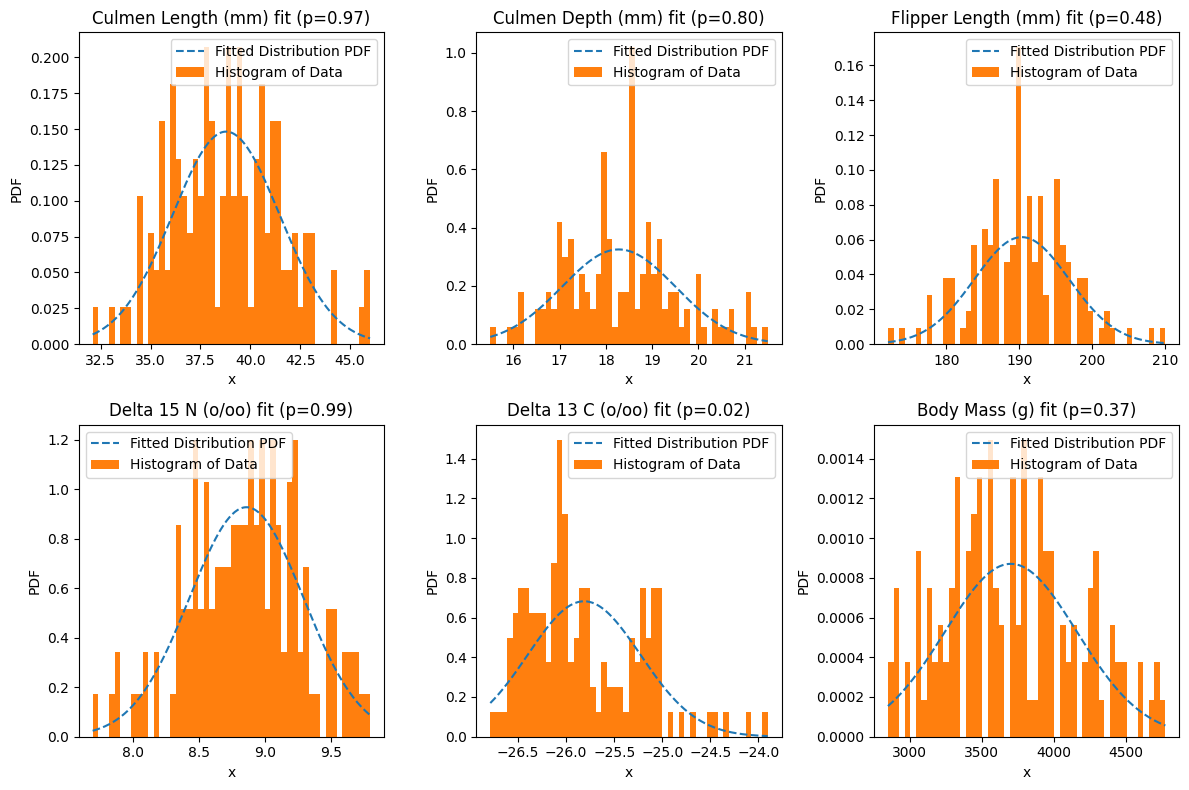

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = axs.ravel()
dist = stats.norm

for i, col in enumerate(features):
    data = floats[col]

    # lets get a good starting point for the parameters
    mu = data.mean()
    sigma = data.std()
    bounds = ((mu - 3 * sigma, mu + 3 * sigma), (0, sigma * 2))
    result = stats.fit(dist, data, bounds=bounds)

    # and plot the fitted result, including the p-values
    result.plot(ax=axs[i])
    kstest = stats.kstest(data, stats.norm(*result.params).cdf)
    axs[i].set_title(f"{col} fit (p={kstest.pvalue:.2f})")

plt.tight_layout()

We are not a penguin expert, but can you come up with possible reasons why the body mass is a lousy fit? E.g. are there possible subgroups you can think of, that would split the distribution into two groups?

It could very wll be that the subgroups turn out to be normally distributed, and we are just looking at two overlapping groups. Another reason could be that there is some other reason that influences our sample, e.g. the penguins are fed a certain diet, or are being hunted etc.

# testing if two distributions are the same
The following code is an example to test if two samples follow the same distribution

Sample sizes: Day Type 1 (Scale=2): 200, Day Type 2 (Scale=3): 250

Exponential fit parameters:
Day Type 1 (Scale=2): location=0.0111, scale=1.8799
Day Type 2 (Scale=3): location=0.0152, scale=3.0074

Testing if datasets follow exponential distributions:
Day Type 1 (Scale=2): KS statistic=0.0526, p-value=0.6184 (follows exponential)
Day Type 2 (Scale=3): KS statistic=0.0617, p-value=0.2858 (follows exponential)

Two-sample KS test: statistic=0.2090, p-value=0.0001
Conclusion: The two distributions are different

Descriptive Statistics:
Day Type 1 (Scale=2): Mean=1.8910, Median=1.3644
Day Type 2 (Scale=3): Mean=3.0226, Median=2.3037


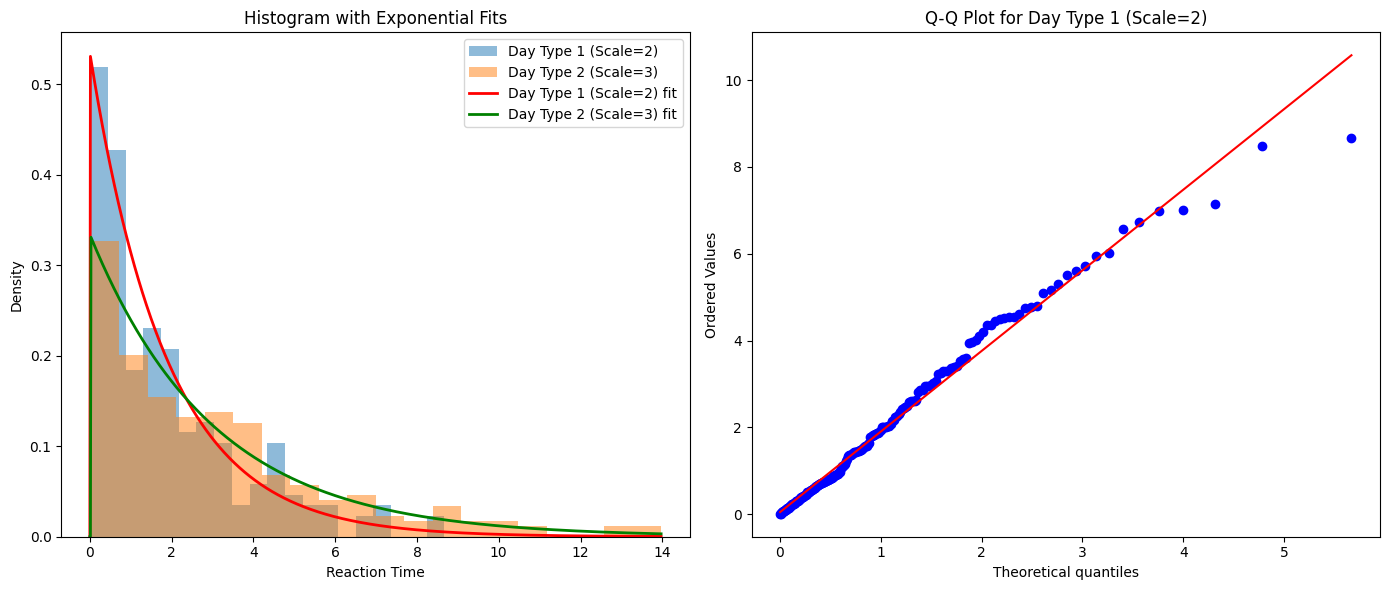

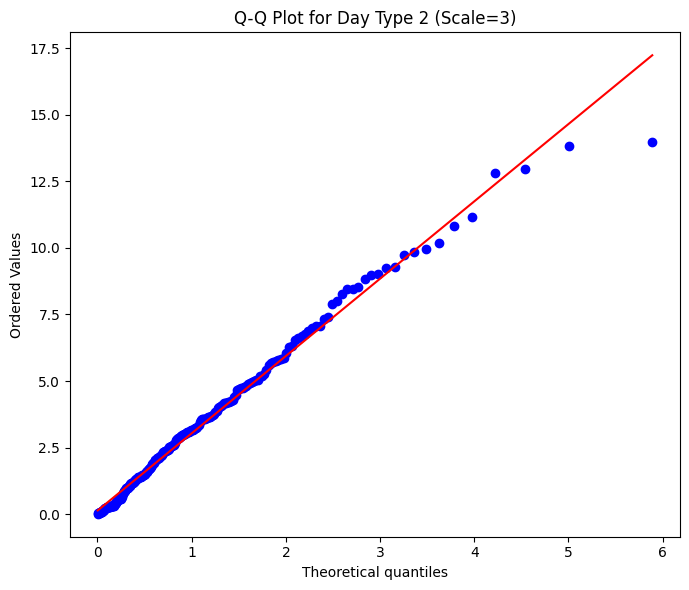



Testing with more similar distributions:
Sample sizes: Day Type 1 (Scale=2.5): 200, Day Type 2 (Scale=2.8): 200

Exponential fit parameters:
Day Type 1 (Scale=2.5): location=0.0285, scale=2.6154
Day Type 2 (Scale=2.8): location=0.0130, scale=2.7558

Testing if datasets follow exponential distributions:
Day Type 1 (Scale=2.5): KS statistic=0.0524, p-value=0.6230 (follows exponential)
Day Type 2 (Scale=2.8): KS statistic=0.0481, p-value=0.7250 (follows exponential)

Two-sample KS test: statistic=0.0750, p-value=0.6284
Conclusion: The two distributions are not significantly different

Descriptive Statistics:
Day Type 1 (Scale=2.5): Mean=2.6439, Median=1.7107
Day Type 2 (Scale=2.8): Mean=2.7688, Median=1.9546


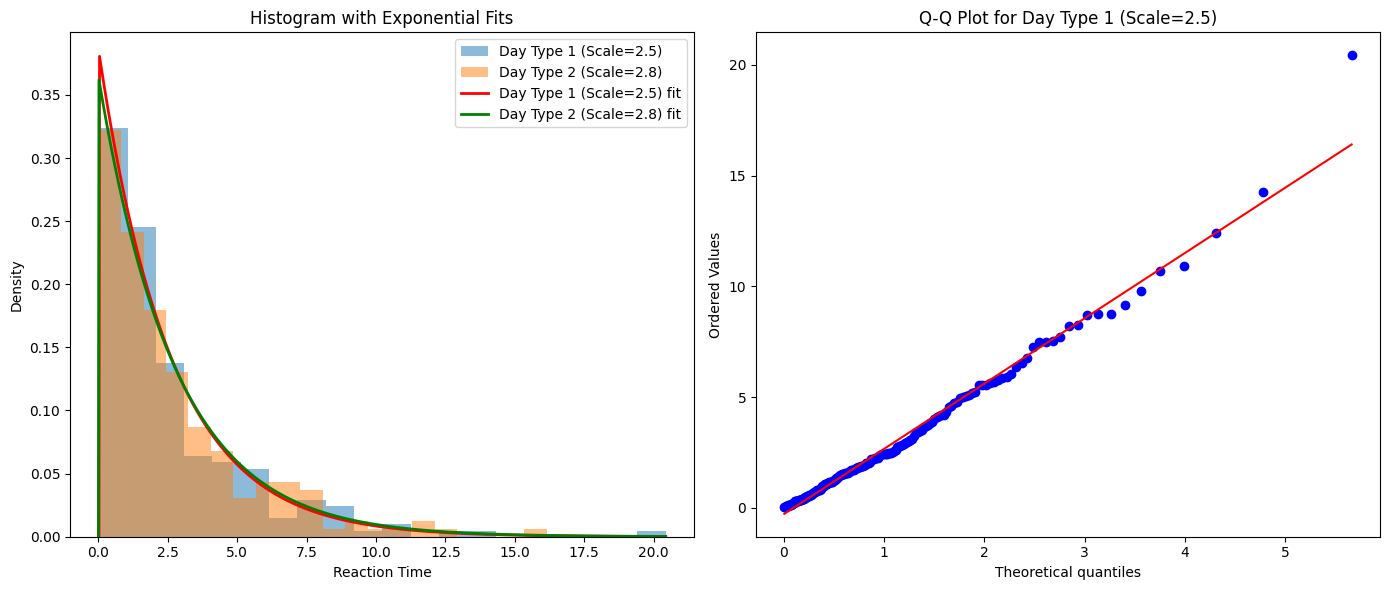

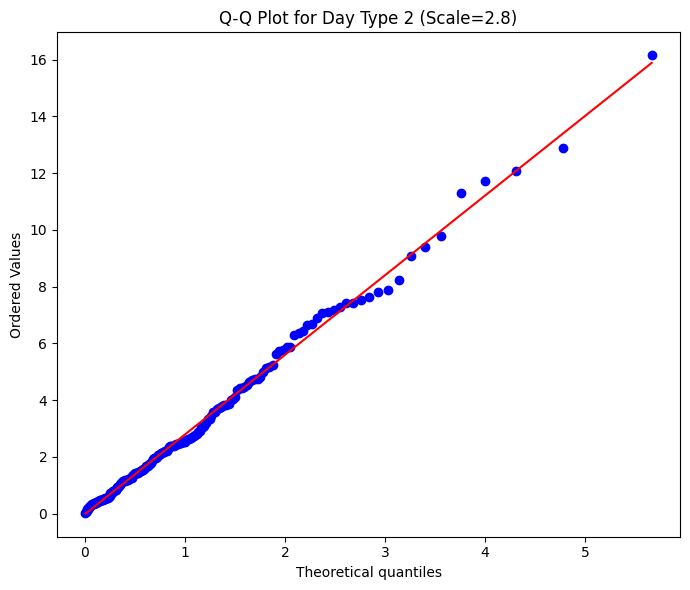

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats


def analyze_reaction_times(data1, data2, label1="Day Type 1", label2="Day Type 2") -> None:
    # 1. Test if each dataset follows an exponential distribution
    print(f"Sample sizes: {label1}: {len(data1)}, {label2}: {len(data2)}")

    # Fit exponential distributions to each dataset
    loc1, scale1 = stats.expon.fit(data1)
    loc2, scale2 = stats.expon.fit(data2)

    print("\nExponential fit parameters:")
    print(f"{label1}: location={loc1:.4f}, scale={scale1:.4f}")
    print(f"{label2}: location={loc2:.4f}, scale={scale2:.4f}")

    # Kolmogorov-Smirnov test for exponential distribution
    ks1, p1 = stats.kstest(data1, "expon", args=(loc1, scale1))
    ks2, p2 = stats.kstest(data2, "expon", args=(loc2, scale2))

    print("\nTesting if datasets follow exponential distributions:")
    print(
        f"{label1}: KS statistic={ks1:.4f}, p-value={p1:.4f} {'(follows exponential)' if p1 > 0.05 else '(does NOT follow exponential)'}"
    )
    print(
        f"{label2}: KS statistic={ks2:.4f}, p-value={p2:.4f} {'(follows exponential)' if p2 > 0.05 else '(does NOT follow exponential)'}"
    )

    # 2. Compare the two distributions
    # Method 1: Two-sample Kolmogorov-Smirnov test
    ks_2samp, p_2samp = stats.ks_2samp(data1, data2)
    print(f"\nTwo-sample KS test: statistic={ks_2samp:.4f}, p-value={p_2samp:.4f}")
    print(
        f"Conclusion: The two distributions are {'different' if p_2samp < 0.05 else 'not significantly different'}"
    )

    # Calculate descriptive statistics
    mean1, mean2 = np.mean(data1), np.mean(data2)
    median1, median2 = np.median(data1), np.median(data2)

    print("\nDescriptive Statistics:")
    print(f"{label1}: Mean={mean1:.4f}, Median={median1:.4f}")
    print(f"{label2}: Mean={mean2:.4f}, Median={median2:.4f}")

    # Visual comparison
    plt.figure(figsize=(14, 6))

    # Histogram plot
    plt.subplot(1, 2, 1)
    plt.hist(data1, bins=20, alpha=0.5, density=True, label=label1)
    plt.hist(data2, bins=20, alpha=0.5, density=True, label=label2)

    # Plot fitted exponential PDFs
    x = np.linspace(0, max(*data1, *data2), 1000)
    plt.plot(x, stats.expon.pdf(x, loc=loc1, scale=scale1), "r-", lw=2, label=f"{label1} fit")
    plt.plot(x, stats.expon.pdf(x, loc=loc2, scale=scale2), "g-", lw=2, label=f"{label2} fit")

    plt.title("Histogram with Exponential Fits")
    plt.xlabel("Reaction Time")
    plt.ylabel("Density")
    plt.legend()

    # Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(data1, dist="expon", plot=plt)
    plt.title(f"Q-Q Plot for {label1}")

    plt.tight_layout()
    plt.show()

    # Another figure for the second Q-Q plot
    plt.figure(figsize=(7, 6))
    stats.probplot(data2, dist="expon", plot=plt)
    plt.title(f"Q-Q Plot for {label2}")
    plt.tight_layout()
    plt.show()


# Generate sample data from two different exponential distributions
np.random.seed(42)  # For reproducibility

# Day 1: Exponential with scale=2 (mean = 2)
reaction_times_day1 = stats.expon.rvs(scale=2, size=200)

# Day 2: Exponential with scale=3 (mean = 3)
reaction_times_day2 = stats.expon.rvs(scale=3, size=250)

# Run analysis on the simulated data
analyze_reaction_times(
    reaction_times_day1,
    reaction_times_day2,
    label1="Day Type 1 (Scale=2)",
    label2="Day Type 2 (Scale=3)",
)

# Let's also run a simulation with very close parameters to see the detection sensitivity
print("\n\n" + "=" * 50)
print("Testing with more similar distributions:")
print("=" * 50)

# Generate two sets with closer parameters
similar_times_1 = stats.expon.rvs(scale=2.5, size=200)
similar_times_2 = stats.expon.rvs(scale=2.8, size=200)

analyze_reaction_times(
    similar_times_1,
    similar_times_2,
    label1="Day Type 1 (Scale=2.5)",
    label2="Day Type 2 (Scale=2.8)",
)